In [1]:
!pip install torch
!pip install torchvision

In [2]:
!git clone https://github.com/manojkyresearch006/Image-Classification-Colab-and-PyTorch.git
import sys
sys.path.append("Image-Classification-Colab-and-PyTorch")

Cloning into 'Image-Classification-Colab-and-PyTorch'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 19), reused 13 (delta 6), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import numpy as np

In [4]:

train_transform=transforms.Compose(
    [transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

valid_transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=valid_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=valid_transform)
valid_size=0.1
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_indices=indices[split:]
valid_indices=indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)




trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,num_workers=2)

valloader= torch.utils.data.DataLoader(valset, batch_size=batch_size, sampler=valid_sampler,num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


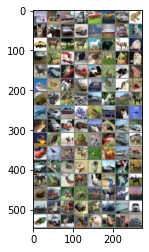

 ship plane truck truck   car   car   car  frog   cat horse   car truck  deer truck   car   dog   car horse  deer horse horse  bird  deer   cat   car  deer truck   dog  bird   dog  frog   dog horse truck  frog truck truck   cat   dog  frog  ship  deer   dog  ship truck   cat   cat  deer   dog   car  deer plane plane horse plane horse plane   car truck truck  frog   car   cat plane  frog   car truck   dog  ship  frog plane   car  deer  bird horse  frog   dog   car   car   cat   car  bird  frog  deer  deer  deer plane  deer   car  bird  deer  frog  bird  ship   dog  deer horse  frog  deer  deer   cat  bird   dog horse  frog truck horse  frog  deer horse  ship  ship plane  ship truck  bird   cat   car  ship   car truck truck horse  deer   dog truck   cat   car


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [6]:

from model import *
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
print("Number of GPU's available are {}".format(torch.cuda.device_count()))
print("Name of the GPU available is {}".format(torch.cuda.get_device_name(0)))
dev=torch.device('cuda:0')
net=net.to(dev)

Number of GPU's available are 0


RuntimeError: ignored

In [ ]:
num_epochs=200
num_batches=len(trainloader)
train_len=batch_size*num_batches

In [ ]:
def softmax(output):
  #num=np.exp(output)
  #denom=np.sum(num,axis=0)
  #shape=denom.shape[0]
  #denom=np.reshape(denom,(shape,1))
  #return num/denom
  func=torch.nn.Softmax(dim=1)
  return func(output)

def validation(loader,Model):
  total=0
  all_correct=0
  batch_loss=0
  num_val_batches=len(loader)
  with torch.no_grad():
    for j, data in enumerate(loader,0):
      inputs,labels=data
      inputs=inputs.to(dev)
      labels=labels.to(dev)
      outputs=Model(inputs)
      val_loss=criterion(outputs,labels)
      batch_loss=batch_loss+val_loss.item()
      #outputs_cpu=softmax(outputs.cpu())
      #preds=torch.argmax(outputs_cpu,dim=1).numpy()
      _, val_preds = torch.max(outputs,1)
      all_correct += torch.sum(val_preds == labels.data)
      labels=labels.cpu().numpy()
      total=total+len(labels)
      #correct=(preds==labels).sum()
      #all_correct=all_correct+correct
  accuracy=all_correct/total
  validation_loss=batch_loss/num_val_batches
  return [accuracy,validation_loss]
      

In [ ]:
train_loss=[]
val_loss=[]
val_accuracy=[]
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(dev)
        labels=labels.to(dev)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    accuracy,validation_loss=validation(valloader,net)
    running_loss=running_loss/num_batches
    train_loss.append(running_loss)
    val_loss.append(validation_loss)
    val_accuracy.append(accuracy)
    print("loss aftet epoch {} is {} val loss is {} and accuracy is {} ".format(epoch,running_loss,validation_loss,accuracy))
print('Finished Training')

In [ ]:
Epochs=np.arange(num_epochs)
plt.plot(Epochs,train_loss)
plt.plot(Epochs,val_loss,'--')

In [ ]:
print(validation(testloader,net))